In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

## Neural Network With NAICS Numeric Feature
Add NAICS as a feature in the network (integer, rescaled to -1, 1). No embeddings, simple sequential model

*This script takes about 2 hours on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection

In [4]:
import pandas as pd
import os
import re

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow.keras.metrics as km

In [6]:
from sba_gnn.sba_gnn import sg_plot 

## Input Data

In [7]:
business_data = pd.read_parquet(Path(setup.temp_path).joinpath('10_DATA_combined_scaled_all.parquet'))

##### NAICS 
Rescale to -1 1 based on range of codes

In [8]:
# NAICS ranges based on code set.
naics_range = [100000, 999999]
out_range = [-1, 1]

In [9]:
X_naics = business_data[['LoanNr_ChkDgt', 'dset', 'NAICS_orig']].set_index('LoanNr_ChkDgt').sort_index()

In [10]:
# Make numeric
X_naics['NAICS_rescale'] = X_naics['NAICS_orig'].astype('int')

In [11]:
# Min/max scale to -1, 1 (based on code ranges, not data)
X_naics['NAICS_rescale'] = (X_naics['NAICS_rescale'] - naics_range[0]) / \
    (naics_range[1] - naics_range[0])
X_naics['NAICS_rescale'] = X_naics['NAICS_rescale'] * (out_range[1] - out_range[0]) + out_range[0]

In [12]:
X_naics['NAICS_rescale'].describe()

count    688081.000000
mean         -0.078918
std           0.384886
min          -0.975311
25%          -0.281221
50%          -0.084152
75%           0.158666
max           0.840269
Name: NAICS_rescale, dtype: float64

In [13]:
X_naics.to_parquet(Path(setup.temp_path).joinpath('13_NAICS_recode.parquet'))

In [14]:
X_naics.head()

,dset,NAICS_orig,NAICS_rescale
LoanNr_ChkDgt,,,
1000014003,train,451120,-0.219732
1000024006,test,722410,0.383135
1000034009,train,621210,0.158246
1000084002,val,332721,-0.482842
1000094005,train,811118,0.580264


##### Get the remaining features

In [15]:
with open(Path(setup.temp_path).joinpath('10_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

In [16]:
base_features = [f for f in imputer_features if 'NAICS' not in f]
features = base_features + ['NAICS_rescale']
print(features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag', 'NAICS_rescale']


##### Datasets for train, validation

In [17]:
X = pd.concat([business_data[['dset', 'LoanNr_ChkDgt'] + base_features] \
               .set_index('LoanNr_ChkDgt').sort_index(),
               X_naics[['NAICS_rescale']]], axis=1)

In [18]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
y_train = business_data[business_data['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'training X: {X_train.shape}, y:{y_train.shape}')

training X: (425594, 11), y:(425594,)


In [19]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
y_val = business_data[business_data['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'val X: {X_val.shape}, y:{y_val.shape}')

val X: (126041, 11), y:(126041,)


In [20]:
base_thresh = y_train.mean()
print(base_thresh)

0.20307382152943884


## Function to create model

In [21]:
def create_model(n_feat = len(features), 
                 hidden_size = setup.nn_layer_sizes,
                 activation='tanh', lr=setup.nn_learning_rate,
                 opt_func = setup.nn_optimizer, dropout = setup.nn_dropout):
    
    n_layers = len(hidden_size)
    model = Sequential()
    model.add(Dense(hidden_size[0], input_shape=(n_feat,), activation=activation))
    for i in range(1, n_layers):
        model.add(Dropout(dropout))
        model.add(Dense(hidden_size[i], input_shape=(hidden_size[i-1],), activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    optimizer = opt_func(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, 
                  metrics=[km.AUC(curve='PR'), km.AUC(curve='ROC')])
    return model

## Create, fit model

In [22]:
this_model = create_model()

2024-02-17 20:08:42.069944: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-17 20:08:42.069961: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-17 20:08:42.069965: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-17 20:08:42.069991: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-17 20:08:42.070004: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [23]:
this_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1536      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9857 (38.50 KB)
Trainable params: 9857 (38.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
this_history = this_model.fit(X_train, y_train,
                              validation_data=(X_val, y_val),
                              batch_size=setup.nn_batch_size,
                              epochs=setup.nn_epochs)

Epoch 1/20


2024-02-17 20:08:42.541553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13300/13300 [==============================] - ETA: 0s - loss: 0.4722 - auc: 0.3062 - auc_1: 0.6739

2024-02-17 20:11:11.147738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13300/13300 [==============================] - 177s 13ms/step - loss: 0.4722 - auc: 0.3062 - auc_1: 0.6739 - val_loss: 0.4677 - val_auc: 0.3293 - val_auc_1: 0.6920
Epoch 2/20
13300/13300 [==============================] - 194s 15ms/step - loss: 0.4662 - auc: 0.3219 - auc_1: 0.6873 - val_loss: 0.4655 - val_auc: 0.3359 - val_auc_1: 0.6961
Epoch 3/20
13300/13300 [==============================] - 172s 13ms/step - loss: 0.4650 - auc: 0.3266 - auc_1: 0.6908 - val_loss: 0.4666 - val_auc: 0.3402 - val_auc_1: 0.6990
Epoch 4/20
13300/13300 [==============================] - 173s 13ms/step - loss: 0.4644 - auc: 0.3293 - auc_1: 0.6925 - val_loss: 0.4644 - val_auc: 0.3403 - val_auc_1: 0.6997
Epoch 5/20
13300/13300 [==============================] - 172s 13ms/step - loss: 0.4641 - auc: 0.3306 - auc_1: 0.6935 - val_loss: 0.4648 - val_auc: 0.3392 - val_auc_1: 0.6985
Epoch 6/20
13300/13300 [==============================] - 1069s 80ms/step - loss: 0.4638 - auc: 0.3313 - auc_1: 0.6945 - val_loss: 0.463

In [25]:
this_history_df = pd.DataFrame(this_history.history)

In [26]:
# Rename columns
try:
    this_history_df.columns = ['_'.join(c.split('_')[0:-1])  \
                               if re.search(r'_\d+$', c) else c for c in this_history_df.columns]
except:
    pass
try:
    cur_col = list(this_history_df.columns)
    this_history_df.columns = [cur_col[0]] + \
        [f'{cur_col[i]}_roc'  if (cur_col[i] == cur_col[i-1]) and 'auc'in cur_col[i] \
         else cur_col[i] for i in range(1, len(cur_col))]
except:
    pass

In [27]:
this_history_df.columns

Index(['loss', 'auc', 'auc_roc', 'val_loss', 'val_auc', 'val_auc_roc'], dtype='object')

In [28]:
this_history_df.to_csv(Path(setup.temp_path).joinpath('13_REPORT_fit_history.csv'))

<Axes: >

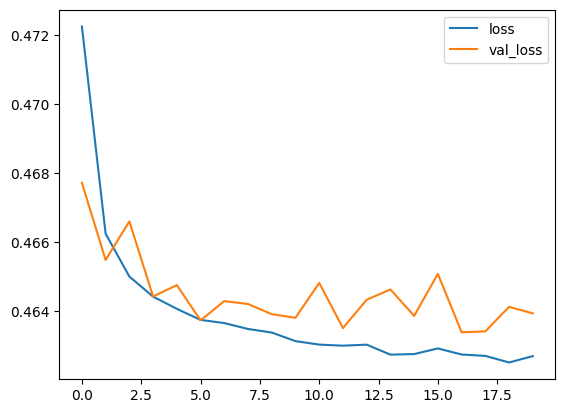

In [29]:
this_history_df[['loss', 'val_loss']].plot()

<Axes: >

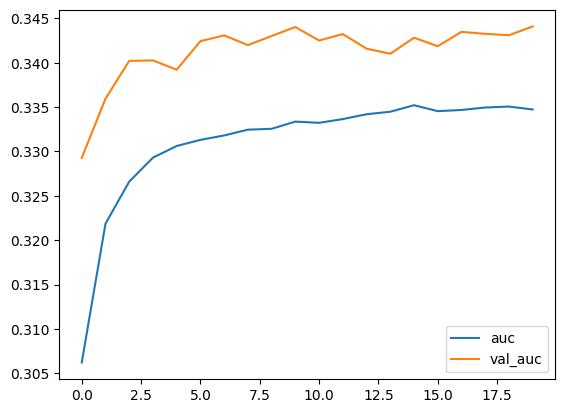

In [30]:
this_history_df[['auc', 'val_auc']].plot()

<Axes: >

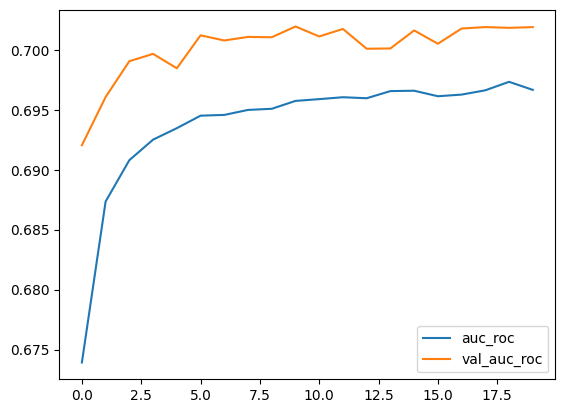

In [31]:
this_history_df[['auc_roc', 'val_auc_roc']].plot()

In [32]:
this_model.save(Path(setup.temp_path).joinpath('13_DATA_model.keras'),save_format='tf')

## Predictions on all data

In [33]:
all_predictions = this_model.predict(X.drop(columns='dset'))

   87/21503 [..............................] - ETA: 38s

2024-02-18 11:51:44.657164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21503/21503 [==============================] - 807s 38ms/step


In [34]:
all_predictions_df = pd.DataFrame(all_predictions, index=X.index) \
    .set_axis(['predict_prob'], axis=1) \
    .reset_index() \
    .merge(business_data[['target', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout']], on='LoanNr_ChkDgt')
    

In [35]:
all_predictions_df[['predict_prob', 'target']].corr(method='spearman')

,predict_prob,target
predict_prob,1.000000,0.281833
target,0.281833,1.000000


##### Threshold Tune & Binary Predictions
Using training probability predictions

In [36]:
all_pred_train = all_predictions_df[all_predictions_df['dset'] == 'train']

In [37]:
thresh_tune_data = sg_plot.get_f1_frame(all_pred_train['target'], 
                                        all_pred_train['predict_prob'])

In [38]:
thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
thresh_tune_data.head(3)

,thresh,f1
10,0.20,0.427691
11,0.22,0.426408
9,0.18,0.425951


In [39]:
best_thresh = thresh_tune_data['thresh'].iloc[0]
best_thresh

0.2

##### Append binary predictions to probability predictions

In [40]:
all_predictions_df['predict_bin'] = sg_plot.get_binary_predictions(all_predictions_df['predict_prob'], best_thresh)

In [41]:
all_predictions_df['predict_bin'].value_counts(normalize=True, dropna=False)

predict_bin
1    0.503214
0    0.496786
Name: proportion, dtype: float64

In [42]:
all_predictions_df.to_parquet(Path(setup.temp_path).joinpath('13_DATA_predictions.parquet'))

## Metrics

In [43]:
metrics_dset_df = all_predictions_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = all_predictions_df[all_predictions_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('13_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.599101,0.427221,0.299375,0.745641,0.345463,0.705815,NaN
1,train,0.595246,0.427691,0.299982,0.744744,0.342561,0.701207,NaN
2,val,0.596925,0.432015,0.304057,0.745927,0.344142,0.701918,NaN
0,test,0.595598,0.429150,0.301184,0.746192,0.346790,0.702886,0.0
1,test,0.609946,0.420940,0.293526,0.743820,0.341461,0.714444,1.0
